# Import Package and Data

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from jcopml.time_series.decomposition import additive_decomposition

pd.set_option('display.float_format', lambda x: '%.4f' % x)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [123]:
df_model = pd.read_csv("data/clean_data_time_series.csv", parse_dates=['date'])
df_model.head()

,date,total_sales,tickets_sold
0,2018-02-21,32030000,267
1,2018-02-22,0,0
2,2018-02-23,180000,3
3,2018-02-24,0,0
4,2018-02-25,0,0


# Pemodelan

## Function

In [124]:
method_list=[] #going to hold the method
algorithm_list = [] #specific algorithm
rmse_list =[] # root mean squared error
mse_list = [] #mean squared error
mae_list = [] #mean absolute error
r2_list = [] #correlation square -tells us how good does the data fit the line
d = {
    'Method': method_list,
    'Algorithm':algorithm_list,
    'MSE': mse_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'R2': r2_list
}

def evaluasi(actual,predicted,method,algorithm):
    #compute metrics
    mse = mean_squared_error(actual,predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual,predicted)
    r2 = r2_score(actual,predicted)
    
    # append list
    method_list.append(method)
    algorithm_list.append(algorithm)
    rmse_list.append(rmse)
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

    result = pd.DataFrame(d)
    return result

In [125]:
def get_forecast_values(data, N, model):
    last_date = data.reset_index().at[len(data)-1, 'date']
    print(f"Tanggal Terakhir\t\t: {last_date}")

    forecast_date = pd.to_datetime(last_date) + pd.DateOffset(days=1)
    print(f"Tanggal Forecast Dimulai Dari\t: {forecast_date}")

    forecast = model.forecast(steps=N) #Forecasting for N days 
    forecast_index = pd.date_range(start=forecast_date, periods=N)
    data_forecast = pd.DataFrame({'Forecast':forecast.values}, index=forecast_index)

    return data_forecast

In [126]:
#visualizing the forecasted values
def forecast_plot(data, data_forecast, method):
    ci = data_forecast.values
    ax = data['tickets_sold'].plot(label='Past Sales', color='black', figsize=(20, 15))
    data_forecast.plot(ax=ax,label='Forecasted Sales', color='darkred')

    ax.set_xlabel('Date')
    ax.set_ylabel('Tickets Sold')
    fig = plt.gcf()
    fig.set_size_inches(12, 4)
    plt.legend()
    
    plt.title(f'Visualizing Forecasted Sales with {method}')
    plt.xlabel('Time')
    plt.ylabel("Tickets Sold")
    return plt.show()

## Forecasting Check

In [127]:
list(df_model['date'].dt.month_name().unique())

['February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November']

<AxesSubplot:xlabel='date'>

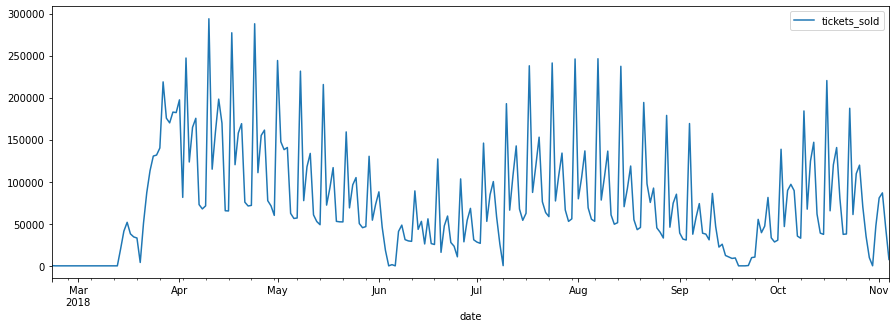

In [128]:
series = df_model.copy()
series.set_index('date', inplace=True)
df_tickets_sold = series[['tickets_sold']]
df_tickets_sold.plot(figsize=(15, 5))

In [129]:
df_tickets_sold.head()

,tickets_sold
date,
2018-02-21,267
2018-02-22,0
2018-02-23,3
2018-02-24,0
2018-02-25,0


## Uji Stationer Data

In [130]:
from statsmodels.tsa.stattools import adfuller
from jcopml.time_series import stationarity_tester
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller

def test_stationarity(data):
    # Menghitung statistik ADF
    result = adfuller(data)
    print('ADF Statistik:', result[0])
    print('P-value:', result[1])
    print('Banyaknya observasi:', result[3])
    print('Nilai kritis:')
    for key, value in result[4].items():
        print('\t', key, ':', value)

    # Melakukan pengecekan p-value
    if result[1] <= 0.05:
        print("Data bersifat stasioner.")
    else:
        print("Data tidak stasioner.")

# Memanggil fungsi untuk menguji kestasioneran data
test_stationarity(df_tickets_sold)

ADF Statistik: -2.837140408794894
P-value: 0.05316124006566649
Banyaknya observasi: 244
Nilai kritis:
	 1% : -3.457437824930831
	 5% : -2.873459364726563
	 10% : -2.573122099570008
Data tidak stasioner.


In [131]:
stationarity_tester(df_tickets_sold)

ADF:        Series is non-stationary
KPSS:       Series is trend stationary
Conclusion: Series is trend stationary. Try detrending the series.


,Test Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%),reject_null
ADF,-2.8371,0.0532,-3.4574,-2.8735,-2.5731,False
KPSS,0.1636,0.1000,0.7390,0.4630,0.3470,False


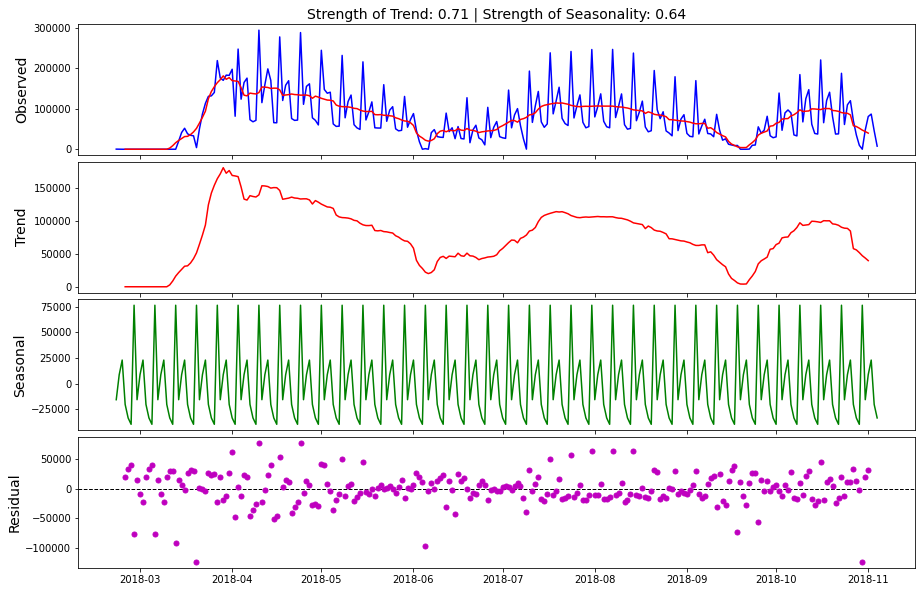

In [132]:
additive_decomposition(df_tickets_sold, plot=True)

In [133]:
df_tickets_sold = df_tickets_sold.diff().fillna(0)
test_stationarity(df_tickets_sold)
df_tickets_sold

ADF Statistik: -4.697392617730033
P-value: 8.510700211277421e-05
Banyaknya observasi: 245
Nilai kritis:
	 1% : -3.4573260719088132
	 5% : -2.873410402808354
	 10% : -2.573095980841316
Data bersifat stasioner.


,tickets_sold
date,
2018-02-21,0.0000
2018-02-22,-267.0000
2018-02-23,3.0000
2018-02-24,-3.0000
2018-02-25,0.0000
...,...
2018-10-31,47575.0000
2018-11-01,33050.0000
2018-11-02,6054.0000


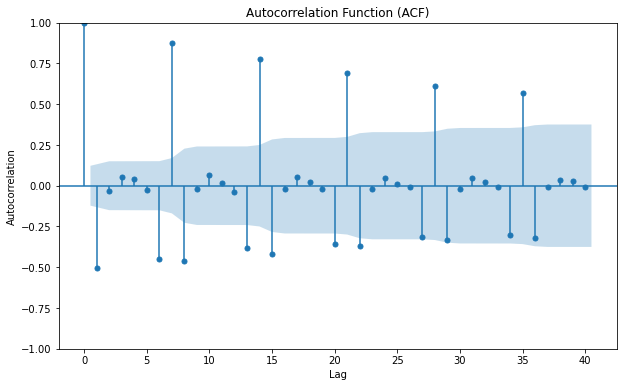

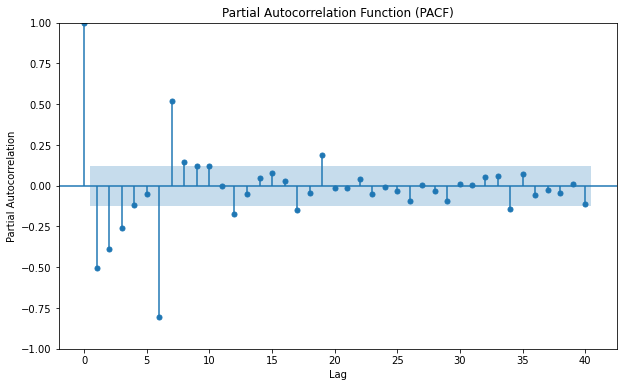

In [134]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(df_tickets_sold, ax=ax, lags=40)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(df_tickets_sold, ax=ax, lags=40)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Forecasting with SARIMAX

In [135]:
data_train, data_test = df_tickets_sold[:-30], df_tickets_sold[-30:]

model_auto_sarimax = auto_arima(df_tickets_sold, start_P=1, start_Q=1, max_P=10, max_Q=10, m=12, start_D=1, max_D=10, random_state=42, 
                                max_order=None, seasonal=True, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True,
                                information_criterion='aicc')

model_auto_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  257
Model:             SARIMAX(4, 0, 3)x(0, 0, [1, 2], 12)   Log Likelihood               -3103.242
Date:                                 Sun, 02 Jul 2023   AIC                           6226.484
Time:                                         17:58:07   BIC                           6261.974
Sample:                                     02-21-2018   HQIC                          6240.756
                                          - 11-04-2018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.1957      0.110    -20.047      0.000      -2.410      -1.981
ar.L2         -2.6020      0.215    -12.124      0.000      -3.023      -2.181
ar.L3         -1.9240      0.208     -9.232      0.000      -2.333      -1.516
ar.L4         -0.8093      0.086     -9.460      0.000      -0.977      -0.642
ma.L1          1.8031      0.150     12.018      0.000       1.509       2.097
ma.L2          1.5471      0.228      6.780      0.000       1.100       1.994
ma.L3          0.5790      0.160      3.621      0.000       0.266       0.892
ma.S.L12      -0.2151      0.164     -1.309      0.190      -0.537       0.107
ma.S.L24      -0.2156      0.169     -1.276      0.202      -0.547       0.116
sigma2      2.961e+09   2.81e-11   1.05e+20      0.000    2.96e+09    2.96e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 7.68
Prob(Q):                              0.72   Prob(JB):                         0.02
Heteroskedasticity (H):               0.77   Skew:                             0.27
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+36. Standard errors may be unstable.
"""

In [136]:
sarimax = SARIMAX(df_tickets_sold,order=(5, 0, 3),
                  seasonal_order=(2, 0, [], 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False)
model_sarimax = sarimax.fit()

pred = model_sarimax.predict()
actual = df_tickets_sold

mse_sarimax = mean_squared_error(actual, pred)
rmse_sarimax = np.sqrt(mse_sarimax)
mae_sarimax = mean_absolute_error(actual,pred)
r2_sarimax = r2_score(actual,pred)

print("MSE\t: ", mse_sarimax)
print("RMSE\t: ", rmse_sarimax)
print("MAE\t: ", mae_sarimax)
print("R2\t: ", r2_sarimax)

evaluasi(actual, pred, "Time Series", "SARIMAX")

MSE	:  1618357522.3806372
RMSE	:  40228.81457836705
MAE	:  29818.062569068923
R2	:  0.6917798292635955


,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,SARIMAX,1618357522.3806,40228.8146,29818.0626,0.6918


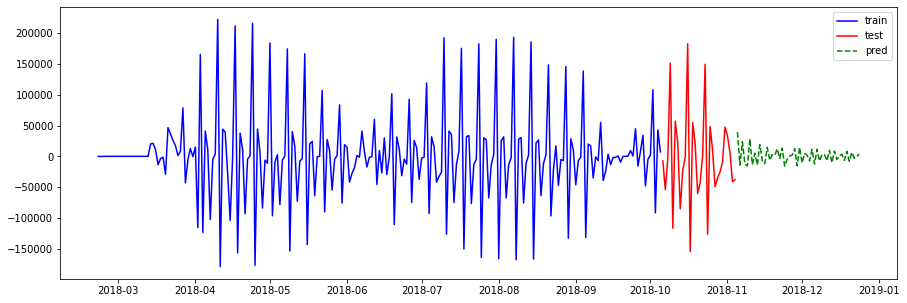

In [137]:
n_forecast = len(data_test) + 20
pred = model_auto_sarimax.predict(n_forecast)

plt.figure(figsize=(15,5))
plt.plot(data_train, "b-", label="train")
plt.plot(data_test, "r-", label="test")
plt.plot(pred, "g--", label="pred")
plt.legend()

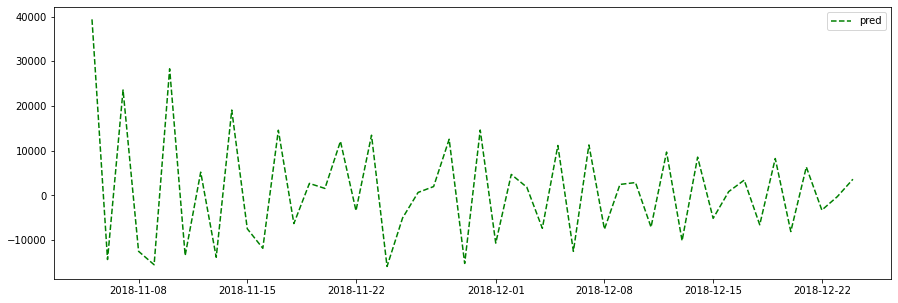

In [138]:
plt.figure(figsize=(15,5))
plt.plot(pred, "g--", label="pred")
plt.legend()

### Visualisasi

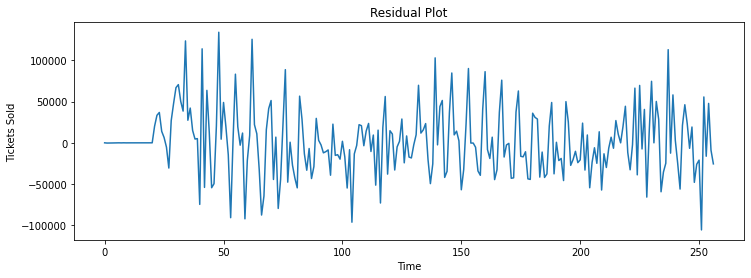

In [139]:
residuals = pd.DataFrame(model_sarimax.resid)
temp_df = residuals.reset_index()
temp_df['date']=pd.to_datetime(temp_df['date'],errors='coerce')
residuals = temp_df.set_index('date')

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.title('Residual Plot')
plt.xlabel('Time')
plt.ylabel("Tickets Sold")
plt.plot(residuals.values )

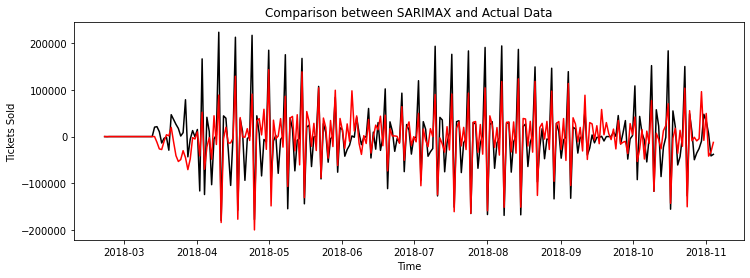

In [140]:
index_list = df_tickets_sold.index.tolist()
preds = model_sarimax.predict()
preds = preds.set_axis(index_list)
preds = preds.to_frame()

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.title(f'Comparison between SARIMAX and Actual Data')
plt.xlabel('Time')
plt.ylabel("Tickets Sold")

plt.plot(df_tickets_sold, label = 'Actual', color = 'black')
plt.plot(preds, label = 'Predicted', color = 'r')

In [141]:
data_forecast = get_forecast_values(df_tickets_sold, 30, model_sarimax) 
data_forecast

Tanggal Terakhir		: 2018-11-04 00:00:00
Tanggal Forecast Dimulai Dari	: 2018-11-05 00:00:00


,Forecast
2018-11-05,15271.0415
2018-11-06,46941.5999
2018-11-07,-23755.4096
2018-11-08,9271.4349
2018-11-09,1577.9044
2018-11-10,7580.5387
2018-11-11,37154.2568
2018-11-12,-72440.0904
2018-11-13,38112.6835
2018-11-14,-2314.5587


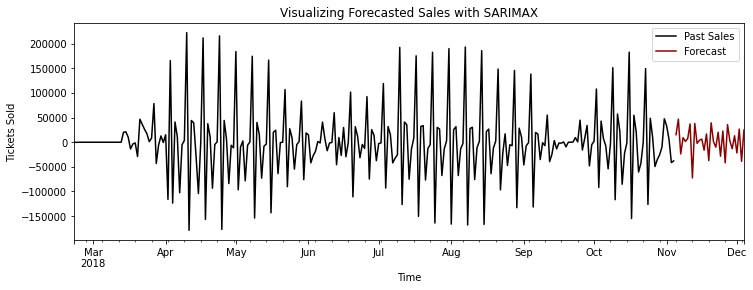

In [142]:
forecast_plot(df_tickets_sold, data_forecast, 'SARIMAX')

# Forecasting with ARIMA

In [143]:
data_train, data_test = df_tickets_sold[:-30], df_tickets_sold[-30:]

model_auto_arima = auto_arima(df_tickets_sold, start_p=1, start_q=1, max_p=10, max_q=10, start_d=1, max_d=10, random_state=42, max_order=None, 
                              seasonal=False, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True, information_criterion='aicc')

model_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  257
Model:               SARIMAX(6, 0, 5)   Log Likelihood               -3012.702
Date:                Sun, 02 Jul 2023   AIC                           6049.404
Time:                        17:58:36   BIC                           6091.993
Sample:                    02-21-2018   HQIC                          6066.531
                         - 11-04-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9904      0.047    -21.073      0.000      -1.083      -0.898
ar.L2         -0.9667      0.062    -15.521      0.000      -1.089      -0.845
ar.L3         -0.9404      0.071    -13.183      0.000      -1.080      -0.801
ar.L4         -0.9446      0.067    -14.122      0.000      -1.076      -0.814
ar.L5         -0.9316      0.070    -13.348      0.000      -1.068      -0.795
ar.L6         -0.8835      0.036    -24.453      0.000      -0.954      -0.813
ma.L1          0.3866      0.067      5.737      0.000       0.255       0.519
ma.L2          0.2839      0.094      3.013      0.003       0.099       0.469
ma.L3          0.2801      0.086      3.259      0.001       0.112       0.449
ma.L4          0.3271      0.100      3.286      0.001       0.132       0.522
ma.L5          0.2500      0.091      2.759      0.006       0.072       0.428
sigma2      9.499e+08   1.01e-10    9.4e+18      0.000     9.5e+08     9.5e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               317.70
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.35
Prob(H) (two-sided):                  0.14   Kurtosis:                         8.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.74e+34. Standard errors may be unstable.
"""

In [144]:
arima = ARIMA(df_tickets_sold, order=(7, 0, 2))
model_arima = arima.fit()

pred = model_arima.predict()
actual = df_tickets_sold

mse_arima = mean_squared_error(actual, pred)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(actual, pred)
r2_arima = r2_score(actual, pred)

print("MSE\t: ", mse_arima)
print("RMSE\t: ", rmse_arima)
print("MAE\t: ", mae_arima)
print("R2\t: ", r2_arima)

evaluasi(actual, pred, "Time Series", "ARIMA")

MSE	:  884148860.7623605
RMSE	:  29734.640753880994
MAE	:  18733.769654009506
R2	:  0.8316116747678222


,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,SARIMAX,1618357522.3806,40228.8146,29818.0626,0.6918
1,Time Series,ARIMA,884148860.7624,29734.6408,18733.7697,0.8316


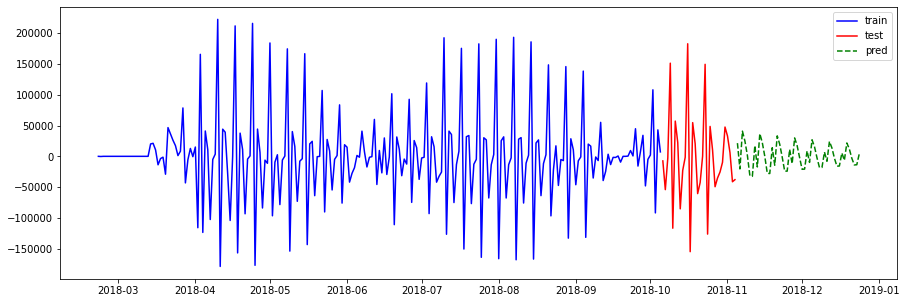

In [145]:
n_forecast = len(data_test) + 20
pred = model_auto_arima.predict(n_forecast)

plt.figure(figsize=(15,5))
plt.plot(data_train, "b-", label="train")
plt.plot(data_test, "r-", label="test")
plt.plot(pred, "g--", label="pred")
plt.legend()

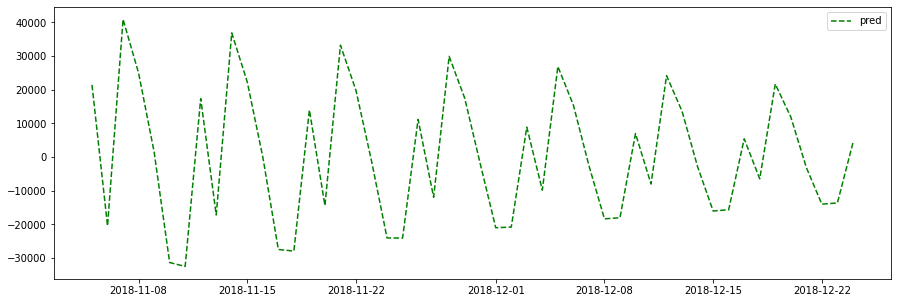

In [146]:
plt.figure(figsize=(15,5))
plt.plot(pred, "g--", label="pred")
plt.legend()

### Visualisasi

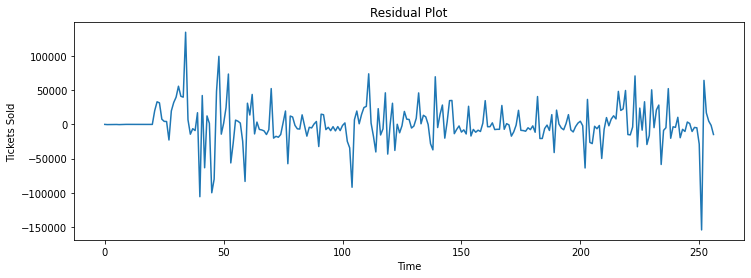

In [147]:
residuals = pd.DataFrame(model_arima.resid)
temp_df = residuals.reset_index()
temp_df['date']=pd.to_datetime(temp_df['date'],errors='coerce')
residuals = temp_df.set_index('date')

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.title('Residual Plot')
plt.xlabel('Time')
plt.ylabel("Tickets Sold")
plt.plot(residuals.values )

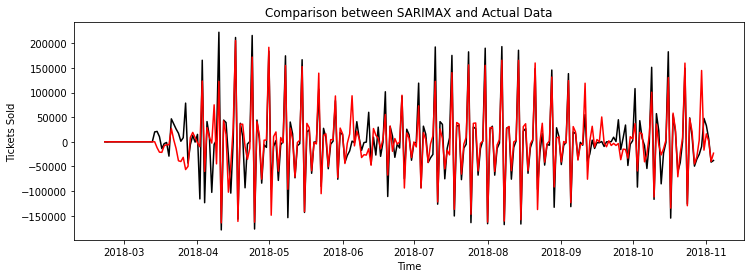

In [148]:
index_list = df_tickets_sold.index.tolist()
preds = model_arima.predict()
preds = preds.set_axis(index_list)
preds = preds.to_frame()

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.title(f'Comparison between SARIMAX and Actual Data')
plt.xlabel('Time')
plt.ylabel("Tickets Sold")

plt.plot(df_tickets_sold, label = 'Actual', color = 'black')
plt.plot(preds, label = 'Predicted', color = 'r')

In [149]:
data_forecast = get_forecast_values(df_tickets_sold, 30, model_arima)
data_forecast

Tanggal Terakhir		: 2018-11-04 00:00:00
Tanggal Forecast Dimulai Dari	: 2018-11-05 00:00:00


,Forecast
2018-11-05,-8345.6837
2018-11-06,-6141.0018
2018-11-07,40223.1247
2018-11-08,27280.0335
2018-11-09,5876.8067
2018-11-10,-32037.6252
2018-11-11,-28394.8271
2018-11-12,-4318.1958
2018-11-13,-5389.4387
2018-11-14,32876.4649


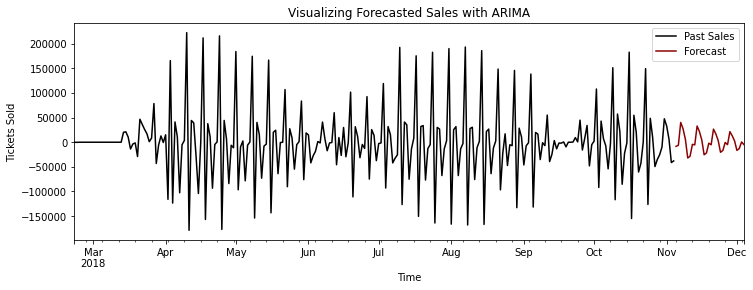

In [150]:
forecast_plot(df_tickets_sold, data_forecast, 'ARIMA')

# Forecast with Model Machine Learning

Shifting the data with 30 periods

In [151]:
df_model_ml = df_model[['date', 'tickets_sold']].copy()
df_model_ml['date'] = pd.to_datetime(df_model_ml['date'])
df_model_ml = df_model_ml.set_index('date')

for lag in range(1, 31):
    df_model_ml[f'lag_{lag}'] = df_model_ml['tickets_sold'].shift(periods=lag)

df_model_ml.fillna(0, inplace=True)
df_model_ml.head()


,tickets_sold,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
date,,,,,,,,,,,,,,,,,,,,,
2018-02-21,267,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2018-02-22,0,267.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2018-02-23,3,0.0000,267.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2018-02-24,0,3.0000,0.0000,267.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2018-02-25,0,0.0000,3.0000,0.0000,267.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [152]:
df_model_ml.to_csv(path_or_buf='data/clean_data_machine_learning.csv', index=False)

### Splitting Data

In [153]:
def train_test_split(data, days):
    X_train = data.iloc[:-days , 1:]  # removing last 30 days and total_sales col
    y_train = data.iloc[:-days , :1] # removing last 30 days and only taking total_Sales col
    X_test = data.iloc[-days: , 1:]  # considering last 30 days without total sales
    y_test = data.iloc[-days: , :1]  # total sales of last 30 days
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split(df_model_ml, 30)

In [154]:
X_train

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
date,,,,,,,,,,,,,,,,,,,,,
2018-02-21,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2018-02-22,267.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2018-02-23,0.0000,267.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2018-02-24,3.0000,0.0000,267.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2018-02-25,0.0000,3.0000,0.0000,267.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01,28392.0000,33312.0000,81321.0000,47218.0000,39455.0000,55258.0000,10424.0000,9782.0000,381.0000,8.0000,...,30908.0000,37741.0000,38807.0000,74011.0000,57472.0000,37626.0000,169217.0000,30761.0000,31772.0000,39044.0000
2018-10-02,30550.0000,28392.0000,33312.0000,81321.0000,47218.0000,39455.0000,55258.0000,10424.0000,9782.0000,381.0000,...,86099.0000,30908.0000,37741.0000,38807.0000,74011.0000,57472.0000,37626.0000,169217.0000,30761.0000,31772.0000
2018-10-03,138614.0000,30550.0000,28392.0000,33312.0000,81321.0000,47218.0000,39455.0000,55258.0000,10424.0000,9782.0000,...,46787.0000,86099.0000,30908.0000,37741.0000,38807.0000,74011.0000,57472.0000,37626.0000,169217.0000,30761.0000


## Random Forest

In [155]:
model_RF = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=500)
model_RF.fit(X_train, y_train)

print('Training\t:', model_RF.score(X_train, y_train))
print('Testing\t\t:', model_RF.score(X_test, y_test))

Training	: 0.9749402545205842
Testing		: 0.4941696870362906


### Hasil Testing Random Forest 

In [156]:
y_test_pred = model_RF.predict(X_test)

mse_RF = mean_squared_error(y_test,y_test_pred)
rmse_RF = np.sqrt(mse_RF)
mae_RF = mean_absolute_error(y_test,y_test_pred)
r2_RF = r2_score(y_test,y_test_pred)

print("MSE\t: ", mse_RF)
print("RMSE\t: ", rmse_RF)
print("MAE\t: ", mae_RF)
print("R2\t: ", r2_RF)

evaluasi(y_test, y_test_pred, "Machine Learning", "Random Forest")

MSE	:  1512104196.2640615
RMSE	:  38885.78398674844
MAE	:  25573.239133333333
R2	:  0.4941696870362906


,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,SARIMAX,1618357522.3806,40228.8146,29818.0626,0.6918
1,Time Series,ARIMA,884148860.7624,29734.6408,18733.7697,0.8316
2,Machine Learning,Random Forest,1512104196.2641,38885.7840,25573.2391,0.4942


## XGBoost

In [157]:
model_XGB = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=500, objective='reg:squarederror')
model_XGB.fit(X_train.values, y_train.values)

print('Training\t:', model_XGB.score(X_train, y_train))
print('Testing\t\t:', model_XGB.score(X_test, y_test))

Training	: 0.9999999999628941
Testing		: 0.40755719901805887


### Hasil Testing XGBoost

In [158]:
y_test_pred = model_XGB.predict(X_test)

mse_XGB = mean_squared_error(y_test,y_test_pred)
rmse_XGB = np.sqrt(mse_XGB)
mae_XGB = mean_absolute_error(y_test,y_test_pred)
r2_XGB = r2_score(y_test,y_test_pred)

print("MSE\t: ", mse_XGB)
print("RMSE\t: ", rmse_XGB)
print("MAE\t: ", mae_XGB)
print("R2\t: ", r2_XGB)

evaluasi(y_test, y_test_pred, "Machine Learning", "XGBoost")

MSE	:  1771019297.2865565
RMSE	:  42083.48009951835
MAE	:  24821.02314453125
R2	:  0.40755719901805887


,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,SARIMAX,1618357522.3806,40228.8146,29818.0626,0.6918
1,Time Series,ARIMA,884148860.7624,29734.6408,18733.7697,0.8316
2,Machine Learning,Random Forest,1512104196.2641,38885.7840,25573.2391,0.4942
3,Machine Learning,XGBoost,1771019297.2866,42083.4801,24821.0231,0.4076


## Linear Regression

In [159]:
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

print('Training\t:', model_LR.score(X_train, y_train))
print('Testing\t\t:', model_LR.score(X_test, y_test))

Training	: 0.8437899673706695
Testing		: 0.43169448335722704


### Hasil Testing Linear Regression

In [160]:
y_test_pred = model_LR.predict(X_test)

mse_LR = mean_squared_error(y_test,y_test_pred)
rmse_LR = np.sqrt(mse_LR)
mae_LR = mean_absolute_error(y_test,y_test_pred)
r2_LR = r2_score(y_test,y_test_pred)

print("MSE\t: ", mse_LR)
print("RMSE\t: ", rmse_LR)
print("MAE\t: ", mae_LR)
print("R2\t: ", r2_LR)

result = evaluasi(y_test, y_test_pred, "Machine Learning", "Linear Regression")
result

MSE	:  1698864489.6360831
RMSE	:  41217.28387019313
MAE	:  24540.56182999523
R2	:  0.43169448335722704


,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,SARIMAX,1618357522.3806,40228.8146,29818.0626,0.6918
1,Time Series,ARIMA,884148860.7624,29734.6408,18733.7697,0.8316
2,Machine Learning,Random Forest,1512104196.2641,38885.7840,25573.2391,0.4942
3,Machine Learning,XGBoost,1771019297.2866,42083.4801,24821.0231,0.4076
4,Machine Learning,Linear Regression,1698864489.6361,41217.2839,24540.5618,0.4317


## Forecast Model Machine Learning

mengambil tanggal terakhir dari data

In [161]:
df_forecast = df_model_ml.copy()
print(df_forecast.index[-1])
print(df_forecast.index[-1] + pd.DateOffset(days=1))

2018-11-04 00:00:00
2018-11-05 00:00:00


melakukan flip sebanyak 30 data agar data yang di prediksi berada pada kolom total_sales

In [162]:
def get_forecast_date(data):
    forecast_date = data.index[-1] + pd.DateOffset(days=1)
    return forecast_date

def append_row(data):
    new_row = np.flip(np.append(data['tickets_sold'][-30:].values, np.nan)) 
    forecast_date = get_forecast_date(data)
    data.loc[forecast_date] = new_row
    return data, forecast_date

def model_forecast(model, data):
    new_row = np.flip(data['tickets_sold'][-30:].values) 
    ypred = model.predict([new_row.tolist()])

    data, forecast_date = append_row(data)
    data['tickets_sold'].loc[forecast_date] = ypred 
    return data

def model_forecast_n(n, model, data):
    for i in range(n):
        data = model_forecast(model, data)
    return data

In [163]:
df_forecast = df_model_ml.copy()
df_forecast.tail()

,tickets_sold,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
date,,,,,,,,,,,,,,,,,,,,,
2018-10-31,47644,69.0000,9738.0000,35178.0000,70343.0000,119722.0000,109593.0000,61019.0000,187345.0000,37895.0000,...,67403.0000,184161.0000,32834.0000,35375.0000,89459.0000,96911.0000,89690.0000,46726.0000,138614.0000,30550.0000
2018-11-01,80694,47644.0000,69.0000,9738.0000,35178.0000,70343.0000,119722.0000,109593.0000,61019.0000,187345.0000,...,124654.0000,67403.0000,184161.0000,32834.0000,35375.0000,89459.0000,96911.0000,89690.0000,46726.0000,138614.0000
2018-11-02,86748,80694.0000,47644.0000,69.0000,9738.0000,35178.0000,70343.0000,119722.0000,109593.0000,61019.0000,...,146927.0000,124654.0000,67403.0000,184161.0000,32834.0000,35375.0000,89459.0000,96911.0000,89690.0000,46726.0000
2018-11-03,45485,86748.0000,80694.0000,47644.0000,69.0000,9738.0000,35178.0000,70343.0000,119722.0000,109593.0000,...,61632.0000,146927.0000,124654.0000,67403.0000,184161.0000,32834.0000,35375.0000,89459.0000,96911.0000,89690.0000
2018-11-04,7584,45485.0000,86748.0000,80694.0000,47644.0000,69.0000,9738.0000,35178.0000,70343.0000,119722.0000,...,38890.0000,61632.0000,146927.0000,124654.0000,67403.0000,184161.0000,32834.0000,35375.0000,89459.0000,96911.0000


### Random Forest

In [164]:
df_forecast = df_model_ml.copy()
forecast_date = get_forecast_date(df_forecast)
print(forecast_date)

data = model_forecast_n(30, model_RF, df_forecast)
data[['tickets_sold']][-30:]

2018-11-05 00:00:00


,tickets_sold
date,
2018-11-05,14604.1200
2018-11-06,32853.8560
2018-11-07,43386.1240
2018-11-08,68253.5080
2018-11-09,82286.3900
2018-11-10,42511.9180
2018-11-11,32303.8120
2018-11-12,32364.0380
2018-11-13,67337.1100


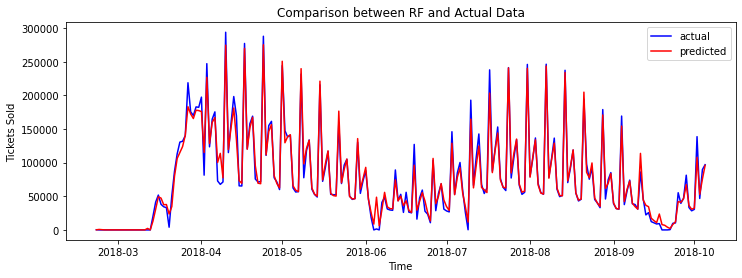

In [165]:
df_plot = df_model_ml.copy()
actual = df_plot['tickets_sold'][:-30]

index_list = actual.index.tolist()
prediction = pd.DataFrame({'prediction': (model_RF.predict(X_train))}, index=index_list)
prediction

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.title(f'Comparison between RF and Actual Data')
plt.xlabel('Time')
plt.ylabel("Tickets Sold")

plt.plot(actual, label = 'actual', color='b' )
plt.plot(prediction, label = 'predicted', color='r' )
plt.legend()

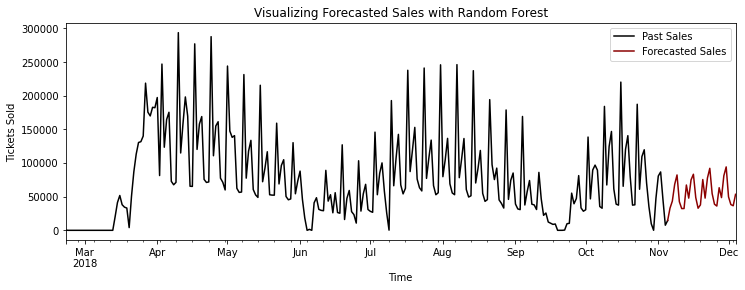

In [166]:
df_actual = df_forecast[['tickets_sold']].loc[:forecast_date]
forecast = df_forecast['tickets_sold'].loc[forecast_date:]

forecast_plot(df_actual, forecast, 'Random Forest')

### XGBoost Regressor

In [167]:
df_forecast = df_model_ml.copy()
forecast_date = get_forecast_date(df_forecast)
print(forecast_date)

data = model_forecast_n(30, model_XGB, df_forecast)
data[['tickets_sold']][-30:]

2018-11-05 00:00:00


,tickets_sold
date,
2018-11-05,2623.5310
2018-11-06,13661.2725
2018-11-07,12475.9961
2018-11-08,20427.3750
2018-11-09,27301.3008
2018-11-10,46736.8281
2018-11-11,25140.3047
2018-11-12,11868.0869
2018-11-13,27041.3105


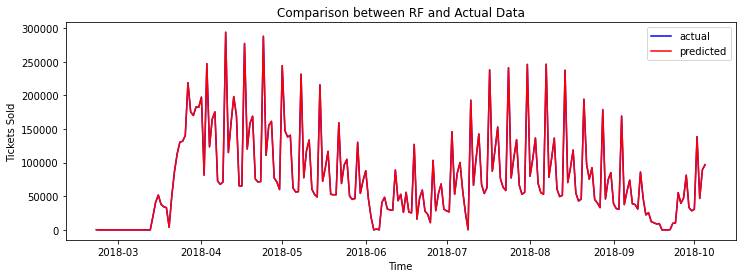

In [168]:
df_plot = df_model_ml.copy()
actual = df_plot['tickets_sold'][:-30]

index_list = actual.index.tolist()
prediction = pd.DataFrame({'prediction': (model_XGB.predict(X_train))}, index=index_list)
prediction

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.title(f'Comparison between RF and Actual Data')
plt.xlabel('Time')
plt.ylabel("Tickets Sold")

plt.plot(actual, label = 'actual', color='b' )
plt.plot(prediction, label = 'predicted', color='r' )
plt.legend()

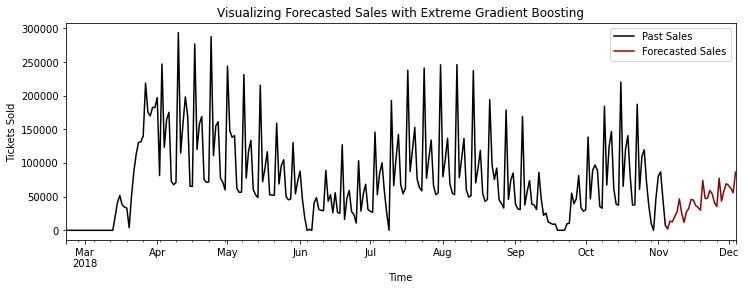

In [169]:
df_actual = df_forecast[['tickets_sold']].loc[:forecast_date]
forecast = df_forecast['tickets_sold'].loc[forecast_date:]

forecast_plot(df_actual, forecast, 'Extreme Gradient Boosting')

### Linear Regresssion

In [170]:
df_forecast = df_model_ml.copy()
forecast_date = get_forecast_date(df_forecast)
print(forecast_date)

data = model_forecast_n(30, model_LR, df_forecast)
data[['tickets_sold']][-30:]

2018-11-05 00:00:00


,tickets_sold
date,
2018-11-05,15407.4020
2018-11-06,10344.8916
2018-11-07,48166.4750
2018-11-08,59504.9796
2018-11-09,76126.1297
2018-11-10,72052.4120
2018-11-11,27802.0681
2018-11-12,-4326.3858
2018-11-13,14995.4470


In [171]:
data_pred = model_LR.predict(X_train)
pred_LR = []
for n in range(len(data_pred)):
    for item in data_pred[n]:
        pred_LR.append(item)

print(pred_LR)

[10070.04070840319, 10174.965800790664, 10122.117203770487, 10106.849067567739, 10097.467391563348, 10060.708326549246, 10028.713254886956, 10296.951665246203, 9970.89921269007, 10050.864740751083, 10053.476914642406, 10002.439817883238, 10055.173765051735, 10160.792037017402, 10076.320174627444, 10063.997162738457, 10043.415283975353, 10033.919965242694, 10142.642136507042, 10103.164939171373, 9999.672334987445, 10090.48887427563, 17956.093707345863, 30203.44950197689, 41165.175350142934, 42605.097586014155, 41327.45700889938, 35436.30755114823, 35274.49447579976, 56874.71031013356, 77978.08717202362, 80797.88560225094, 98393.04165194706, 106469.05500907905, 86303.51189521342, 175473.60174836332, 191739.42759104192, 189856.81789165514, 195655.6364287016, 170266.0613144243, 156949.05464035692, 194220.86716133976, 175182.4221130186, 152812.59255304324, 171448.2442585497, 145688.49539601727, 135202.10409650934, 39627.77826067819, 204317.98568536126, 114394.71746290481, 153960.5435415835,

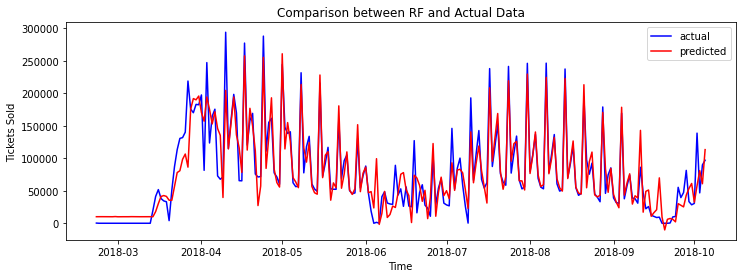

In [172]:
df_plot = df_model_ml.copy()
actual = df_plot['tickets_sold'][:-30]

index_list = actual.index.tolist()
prediction = pd.DataFrame({'prediction': (pred_LR)}, index=index_list)
prediction

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.title(f'Comparison between RF and Actual Data')
plt.xlabel('Time')
plt.ylabel("Tickets Sold")

plt.plot(actual, label = 'actual', color='b' )
plt.plot(prediction, label = 'predicted', color='r' )
plt.legend()

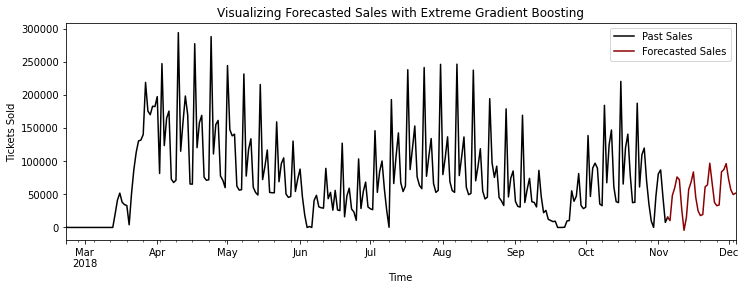

In [173]:
df_actual = df_forecast[['tickets_sold']].loc[:forecast_date]
forecast = df_forecast['tickets_sold'].loc[forecast_date:]

forecast_plot(df_actual, forecast, 'Extreme Gradient Boosting')

# Kesimpulan

In [174]:
result

,Method,Algorithm,MSE,RMSE,MAE,R2
0,Time Series,SARIMAX,1618357522.3806,40228.8146,29818.0626,0.6918
1,Time Series,ARIMA,884148860.7624,29734.6408,18733.7697,0.8316
2,Machine Learning,Random Forest,1512104196.2641,38885.7840,25573.2391,0.4942
3,Machine Learning,XGBoost,1771019297.2866,42083.4801,24821.0231,0.4076
4,Machine Learning,Linear Regression,1698864489.6361,41217.2839,24540.5618,0.4317


Berdasarkan hasil evaluasi diatas didapatkan bahwa algoritma ARIMA memiliki nilai R2 tertinggi yaitu 83,16%